#Yêu cầu chủ đề.

Xây dựng phần mềm nhận dạng 5 đối tượng trong phòng
* a. Xây dựng, thu thập tập dữ liệu các đối tượng cần nhận dạng
* b. Phân lớp các đối tượng trên
* c. Tìm gốc quay của đối tượng
* d. Triển khai mô hình (web, desktop)




# Giới thiệu.
- Dataset được thu thập từ 5 vật dụng định sẵn thường có trong phòng: Bottle, Headphone, Mouse, Pen, Sneaker.
- Thu thập bằng cách tải ảnh và thu thập từ các dataset.


# 1 - Chuẩn bị dữ liệu.

Dataset nhóm sử dụng có 3 phần: train, test và valid.
- Dataset ban đầu được chia 7 phần train 3 phần test, train 3500(700 1 class), test 1500.
- Sau đó từ tập test (1500) chia thành 6 phần test 900 (180 1 class), 4 phần valid 600 (120).


* Mục tiêu chính của bài toán phân loại này là tìm ra mối quan hệ, mẫu hoặc đặc trưng của các vật để có thể dự đoán nhãn của các ảnh chưa được biết trước.

## 1.1 Tải và uzip Dataset.

In [ ]:
%%shell
#https://drive.google.com/file/d/12eKyOde5LgYbUwqamA1iTIzq9pgBxpXY/view?usp=sharing
gdown -q 12eKyOde5LgYbUwqamA1iTIzq9pgBxpXY
rm -rf /content/Data
mkdir -p /content/Data
unzip -q 5Thing.zip -d /content/Data

#Import libary

In [ ]:
import os
import shutil
import random
import progressbar
import cv2
import h5py
import imutils
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from joblib import dump, load
import plotly.express as px
from google.colab import drive
from keras.models import load_model

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from keras.applications import imagenet_utils
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, Sequential, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# # Mount Google Drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Đường dẫn đến thư mục chứa dữ liệu
path_to_data = '/content/Data/5Thing'

# Đường dẫn đến thư mục chứa dữ liệu đã được chia
path_to_train = '/content/Train'
path_to_test = '/content/Test'
path_to_valid = '/content/Valid'

# Tạo các thư mục nếu chúng không tồn tại
os.makedirs(path_to_train, exist_ok=True)
os.makedirs(path_to_test, exist_ok=True)
os.makedirs(path_to_valid, exist_ok=True)

# Tạo thư mục train/test/valid cho từng class
classes = os.listdir(path_to_data)
for class_name in classes:
    os.makedirs(os.path.join(path_to_train, class_name), exist_ok=True)
    os.makedirs(os.path.join(path_to_test, class_name), exist_ok=True)
    os.makedirs(os.path.join(path_to_valid, class_name), exist_ok=True)

#Split Train - Valid - Test


In [ ]:
# Chia dữ liệu thành tập train/test/valid
for class_name in classes:
    class_path = os.path.join(path_to_data, class_name)
    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42) #train 3500(700 1 class), test 1500
    test_images, valid_images = train_test_split(test_images, test_size=0.4, random_state=42) #test 900 (180 1 class), valid 600 (120)

    for image in train_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(path_to_train, class_name, image)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(path_to_test, class_name, image)
        shutil.copy(src, dest)

    for image in valid_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(path_to_valid, class_name, image)
        shutil.copy(src, dest)

#Show the amount of data

In [ ]:
def viz_class(x, NoD):
    class_names = list(filter(lambda f: os.path.isdir(os.path.join(x, f)),
                              os.listdir(x)))
    class_dis = [len(os.listdir(x + f"/{name}")) for name in class_names]
    lk_dis = dict(zip(class_names, class_dis))
    print(f"Class Distribution:\n{lk_dis}")

    fig = px.bar(x=class_dis, y=class_names, color=class_names, width=1000)
    fig.update_layout({'title': {'text': f'{NoD}', 'x': 0.5}},
                      xaxis_title="Số lượng mẫu",
                      yaxis_title="Các lớp của Dataset")
    fig.show()

In [ ]:
viz_class(path_to_train, "Train Set")

Class Distribution:
{'Bottle': 700, 'Headphone': 700, 'Mouse': 700, 'Shoes': 700, 'Pen': 700}


In [ ]:
viz_class(path_to_valid, "Valid Set")

Class Distribution:
{'Bottle': 120, 'Headphone': 120, 'Mouse': 120, 'Shoes': 120, 'Pen': 120}


In [ ]:
viz_class(path_to_test, "Test Set")

Class Distribution:
{'Bottle': 180, 'Headphone': 180, 'Mouse': 180, 'Shoes': 180, 'Pen': 180}


Found 3500 files belonging to 5 classes.


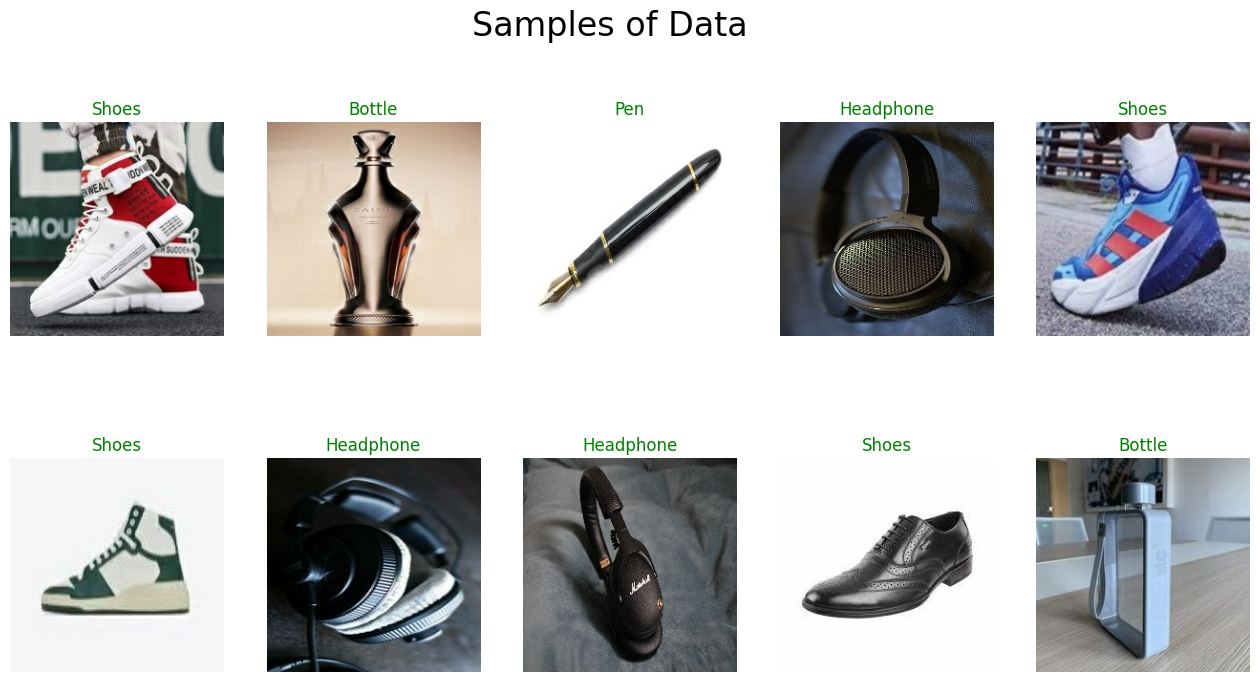

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
  path_to_train,
  image_size=(224, 224),
  batch_size=10,
  shuffle= True)

def show_images(dataset):
  plt.figure(figsize=(16,8))
  plt.suptitle('Samples of Data', fontsize=24)
  for images, labels in dataset.take(1):
    for i in range(10):
      ax = plt.subplot(2, 5, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      ax.set_title(dataset.class_names[labels[i]], color = 'g')
      ax.axis("off")
  plt.show()

show_images(dataset)

#Xây dựng mô hình phân loại ảnh

##Chuẩn bị dữ liệu

In [ ]:
BASE_PATH = "5Thing"

TRAIN_PATH = '/content/Train'
VALID_PATH = '/content/Valid'
TEST_PATH = '/content/Test'

CLASSES = ['Bottle', 'Headphone', 'Mouse', 'Pen', 'Sneaker']

IMG_SIZE = (224, 224)

In [ ]:
train_dataset = image_dataset_from_directory(
 Path.cwd() / BASE_PATH / TRAIN_PATH ,
 image_size=(224, 224),
 batch_size=32,
 label_mode='categorical')

validation_dataset = image_dataset_from_directory(
    Path.cwd() / BASE_PATH / VALID_PATH,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    Path.cwd() / BASE_PATH / TEST_PATH,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

for images_batch, labels_batch in train_dataset:
 print("images batch shape:", images_batch.shape)
 print("labels batch shape:", labels_batch.shape)
 break

Found 3500 files belonging to 5 classes.
Found 600 files belonging to 5 classes.
Found 900 files belonging to 5 classes.
images batch shape: (32, 224, 224, 3)
labels batch shape: (32, 5)


##Xây dựng mô hình

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def ResNet_5Thing(input_shape=(224, 224, 3), num_classes=5):
    # Tạo mô hình ResNet50 với trọng số được đào tạo trước
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Đóng băng trọng số của mô hình ResNet50
    for layer in base_model.layers:
        layer.trainable = False

    # Tạo mô hình phân loại
    model = keras.Sequential([
        # Sử dụng mô hình ResNet50 làm phần trích xuất đặc trưng
        base_model,

        # Làm phẳng đầu ra của mô hình ResNet50
        GlobalAveragePooling2D(),

        # Tầng fully connected
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Số lớp phân loại của bạn
    ])

    return model

# Sử dụng hàm để tạo mô hình
model = ResNet_5Thing()

# In thông tin mô hình
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 23850629 (90.98 MB)
Trainable params: 262917 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="5Thing_Res.hdf5",
    save_best_only=True,
    monitor="val_loss",
    verbose=1)
]

Non-trainable params: 2944 là số lượng tham số không thể học do việc sử dụng chuẩn hóa **Batch**: 64*2 + 128*2 + 256*2 + 512*2 + 512*2 = 2944 (tương ứng cho từng tầng conv2d cộng lại nhân 2)​

In [ ]:
history = model.fit(
    train_dataset,
    epochs= 60,
    validation_data=validation_dataset,
    callbacks=callbacks,
    batch_size=128
)

Epoch 1/60
110/110 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9617
Epoch 1: val_loss improved from inf to 0.05826, saving model to 5Thing_Res.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



110/110 [==============================] - 37s 150ms/step - loss: 0.1122 - accuracy: 0.9617 - val_loss: 0.0583 - val_accuracy: 0.9850
Epoch 2/60
109/110 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9974
Epoch 2: val_loss did not improve from 0.05826
110/110 [==============================] - 13s 120ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.0636 - val_accuracy: 0.9800
Epoch 3/60
109/110 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980
Epoch 3: val_loss improved from 0.05826 to 0.02896, saving model to 5Thing_Res.hdf5
110/110 [==============================] - 15s 130ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0290 - val_accuracy: 0.9883
Epoch 4/60
110/110 [==============================] - ETA: 0s - loss: 8.6475e-04 - accuracy: 1.0000
Epoch 4: val_loss improved from 0.02896 to 0.02422, saving model to 5Thing_Res.hdf5
110/110 [==============================] - 14s 128ms/step - loss: 8.6475e-04 - accuracy: 1.

##Biểu đồ và kết quả huấn luyện

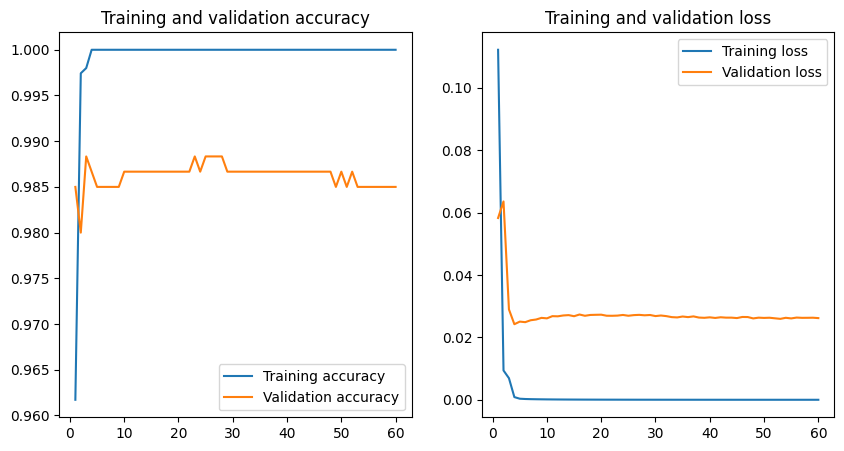

In [ ]:
# Vẽ biểu đồ huấn luyện
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Khi so sánh mô hình này và mô hình sequential thì mô hihf rõ là tốt hơn, khi độ mất mát vô cùng thấp và độ chính xác gần ngưỡng overfitting => Mô hình này được lựa chọn cho câu b (Xây dựng mô hình phân loại đối tượng).

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.2f}")

29/29 [==============================] - 4s 125ms/step - loss: 0.0485 - accuracy: 0.9911
Test accuracy: 0.99


#Lưu model

In [ ]:
# drive_path = '/content/gdrive/MyDrive/DeepLearning/Đồ án/HDF5'
# model_hdf5_path = drive_path + '/5Thing_Res.hdf5'
# model.save(model_hdf5_path)
# print("Model đã được lưu vào:", model_hdf5_path)

Model đã được lưu vào: /content/gdrive/MyDrive/DeepLearning/Đồ án/5Thing_Res.hdf5


#Show prediction


In [ ]:
def show_predictions(dataset, model, class_names):
    count = 0
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
    for images, labels in dataset:
        # Chuyển đổi one-hot encoding thành nhãn
        true_labels = np.argmax(labels, axis=1)

        # Dự đoán trên tập dữ liệu
        predictions = model.predict(images)

        # Chuyển đổi one-hot encoding của dự đoán thành nhãn dự đoán
        predicted_labels = np.argmax(predictions, axis=1)

        # Lấy confidence
        confidence = np.max(predictions, axis=1)

        for i in range(images.shape[0]):  # Use images.shape[0] instead of images_np.shape[0]
            if count >= 10:
                break

            ax = axes[count // 5, count % 5]
            ax.imshow(images[i].numpy().astype(np.uint8))  # Convert EagerTensor to NumPy array

            if predicted_labels[i] == true_labels[i]:
                color = 'g'
            else:
                color = 'r'

            ax.set_title(f"Pred: {class_names[predicted_labels[i]]}-({class_names[true_labels[i]]})({confidence[i]:.2f})", color=color, size=10)
            ax.set(xticks=[], yticks=[])
            count += 1

        if count >= 10:
            break

    title = "Prediction results for images in a batch"
    fig.suptitle(title)
    plt.show()

1/1 [==============================] - 1s 962ms/step


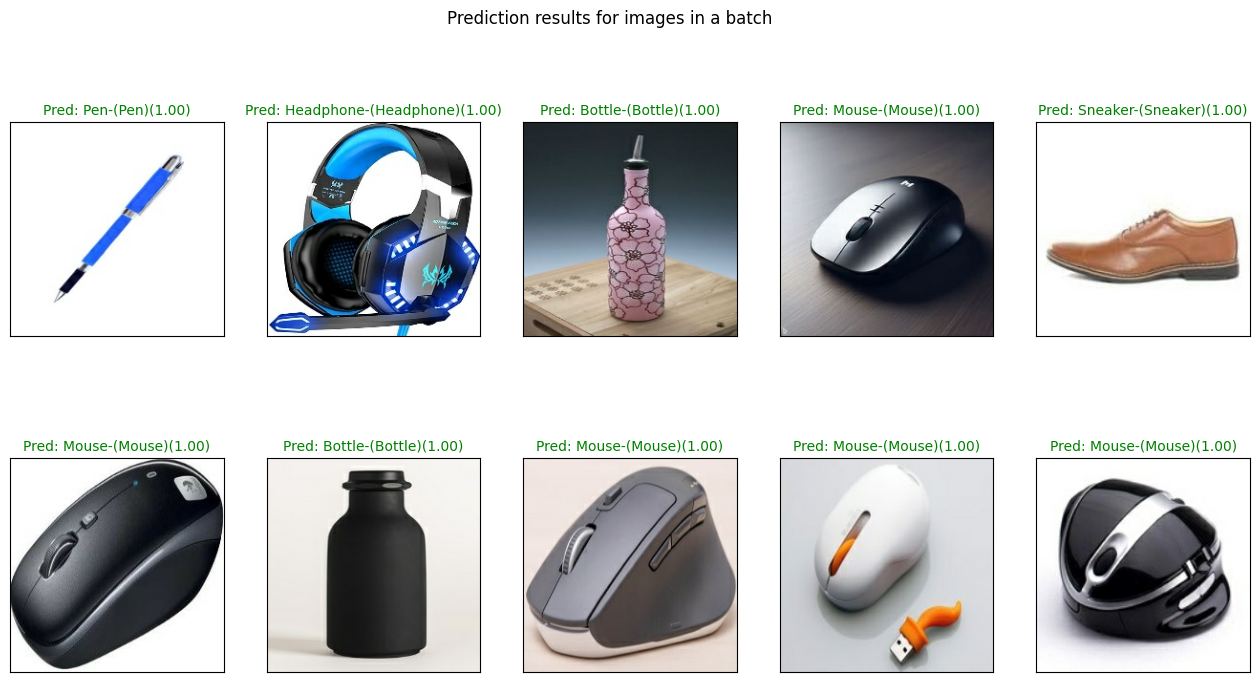

In [ ]:
show_predictions(test_dataset, model, CLASSES)

1/1 [==============================] - 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       180
           1       0.97      0.99      0.98       180
           2       0.98      0.98      0.98       180
           3       1.00      1.00      1.00       180
           4       0.98      1.00      0.99       180

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



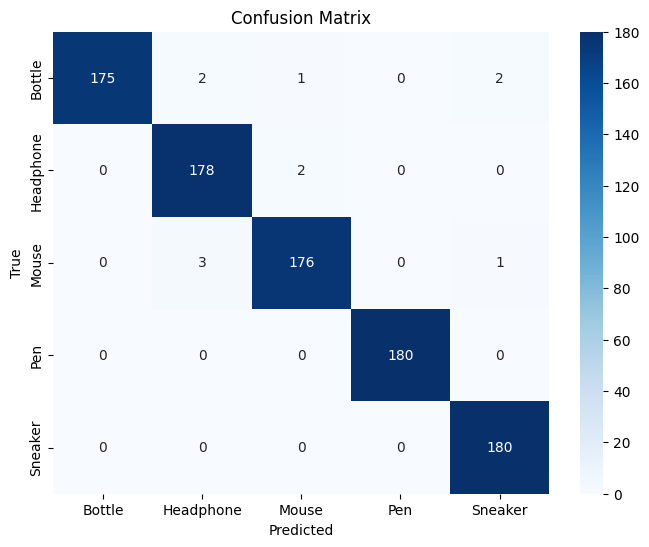

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load model
loaded_model = load_model('/content/5Thing_Res.hdf5')

# Function to evaluate and print classification report
def evaluate_model(model, dataset):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot encoding to labels
        predictions = model.predict(images)
        predicted_labels.extend(np.argmax(predictions, axis=1))

    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate on the test dataset
evaluate_model(loaded_model, test_dataset)